# Image classification with Swin Transformers



This example implements
[Swin Transformer: Hierarchical Vision Transformer using Shifted Windows](https://arxiv.org/abs/2103.14030)
by Liu et al. for image classification, and demonstrates it on the
[MedMNIST dataset].

Swin Transformer (**S**hifted **Win**dow Transformer) can serve as a
general-purpose backbone for computer vision. Swin Transformer is a hierarchical
Transformer whose representations are computed with _shifted windows_. The
shifted window scheme brings greater efficiency by limiting self-attention
computation to non-overlapping local windows while also allowing for
cross-window connections. This architecture has the flexibility to model
information at various scales and has a linear computational complexity with
respect to image size.

This example requires TensorFlow 2.5 or higher.

In [2]:
pip install --upgrade keras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 11.9 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.0.5 which is incompatible.


## Setup

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf  # For tf.data and preprocessing only.
import keras
from keras import layers
from keras import ops

## Configure the hyperparameters

A key parameter to pick is the `patch_size`, the size of the input patches.
In order to use each pixel as an individual input, you can set `patch_size` to
`(1, 1)`. Below, we take inspiration from the original paper settings for
training on ImageNet-1K, keeping most of the original settings for this example.

In [2]:
num_classes = 100
input_shape = (32, 32, 3)

patch_size = (2, 2)  # 2-by-2 sized patches
dropout_rate = 0.03  # Dropout rate
num_heads = 8  # Attention heads
embed_dim = 64  # Embedding dimension
num_mlp = 256  # MLP layer size
# Convert embedded patches to query, key, and values with a learnable additive
# value
qkv_bias = True
window_size = 2  # Size of attention window
shift_size = 1  # Size of shifting window
image_dimension = 32  # Initial image size

num_patch_x = input_shape[0] // patch_size[0]
num_patch_y = input_shape[1] // patch_size[1]

learning_rate = 1e-3
batch_size = 128
num_epochs = 40
validation_split = 0.1
weight_decay = 0.0001
label_smoothing = 0.1

## Prepare the data

We load the MedMNIST dataset through `keras.datasets`,
normalize the images, and convert the integer labels to one-hot encoded vectors.

In [3]:
!unzip data.zip -d data

Streaming output truncated to the last 5000 lines.
  inflating: data/HeadCT/005000.jpeg  
  inflating: data/HeadCT/005001.jpeg  
  inflating: data/HeadCT/005002.jpeg  
  inflating: data/HeadCT/005003.jpeg  
  inflating: data/HeadCT/005004.jpeg  
  inflating: data/HeadCT/005005.jpeg  
  inflating: data/HeadCT/005006.jpeg  
  inflating: data/HeadCT/005007.jpeg  
  inflating: data/HeadCT/005008.jpeg  
  inflating: data/HeadCT/005009.jpeg  
  inflating: data/HeadCT/005010.jpeg  
  inflating: data/HeadCT/005011.jpeg  
  inflating: data/HeadCT/005012.jpeg  
  inflating: data/HeadCT/005013.jpeg  
  inflating: data/HeadCT/005014.jpeg  
  inflating: data/HeadCT/005015.jpeg  
  inflating: data/HeadCT/005016.jpeg  
  inflating: data/HeadCT/005017.jpeg  
  inflating: data/HeadCT/005018.jpeg  
  inflating: data/HeadCT/005019.jpeg  
  inflating: data/HeadCT/005020.jpeg  
  inflating: data/HeadCT/005021.jpeg  
  inflating: data/HeadCT/005022.jpeg  
  inflating: data/HeadCT/005023.jpeg  
  inflating: 

In [6]:
import os
import pandas as pd
path = "./data/"

data = {"imgpath": [] , "labels": [] }

category = os.listdir(path)
for folder in category:
    folderpath = os.path.join(path , folder)
    filelist = os.listdir(folderpath)
    for file in filelist:
        fpath = os.path.join(folderpath, file)
        data["imgpath"].append(fpath)
        data["labels"].append(folder)
df = pd.DataFrame(data)

In [7]:
df

,imgpath,labels
0,./data/CXR/009394.jpeg,CXR
1,./data/CXR/004031.jpeg,CXR
2,./data/CXR/009506.jpeg,CXR
3,./data/CXR/004730.jpeg,CXR
4,./data/CXR/006719.jpeg,CXR
...,...,...
58949,./data/HeadCT/005651.jpeg,HeadCT
58950,./data/HeadCT/006625.jpeg,HeadCT
58951,./data/HeadCT/004193.jpeg,HeadCT
58952,./data/HeadCT/000225.jpeg,HeadCT


X_train shape: (37730, 32, 32, 1) - y_train shape: (37730, 6)
X_val shape: (9433, 32, 32, 1) - y_val shape: (9433, 6)
X_test shape: (11791, 32, 32, 1) - y_test shape: (11791, 6)


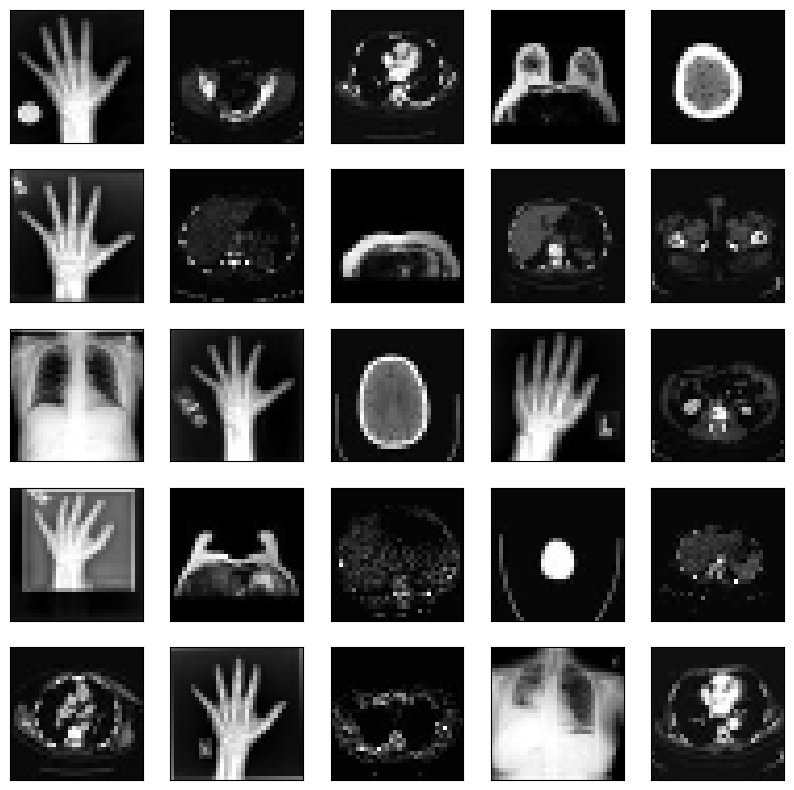

In [15]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow import keras
import cv2  # OpenCV for image processing
from sklearn.preprocessing import LabelEncoder

# Load your DataFrame containing your data
# Assuming df contains your DataFrame with features (image paths) and labels
# Modify this according to your DataFrame structure
# df = pd.read_csv("your_dataset.csv")

# Split features (input) and labels (output)
X_paths = df["imgpath"]  # Assuming "image_path" is the column name containing image paths
y = df["labels"]

# Load and preprocess images from file paths
X_images = []
for path in X_paths:
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)  # Read image in grayscale
    img = cv2.resize(img, (32, 32))  # Resize if necessary
    X_images.append(img)

X_images = np.array(X_images)

# Expand dimensions to add channel dimension (assuming single-channel grayscale)
X_images = np.expand_dims(X_images, axis=-1)

# Perform train-test split
x_train, x_test, y_train, y_test = train_test_split(X_images, y, test_size=0.2, random_state=42)

# Further split into train and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

# Optionally normalize pixel values
x_train = x_train / 255.0
# x_val = x_val / 255.0
x_test = x_test / 255.0

# Convert labels to one-hot encoded format
num_classes = len(np.unique(y))
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)
y_train = keras.utils.to_categorical(y_train_encoded, num_classes=num_classes)
y_val = keras.utils.to_categorical(y_val_encoded, num_classes=num_classes)
y_test = keras.utils.to_categorical(y_test_encoded, num_classes=num_classes)

# Print shapes
print(f"X_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"X_val shape: {x_val.shape} - y_val shape: {y_val.shape}")
print(f"X_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

# Visualize some samples
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap='gray')  # Display in grayscale
plt.show()


In [ ]:
# (x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()
# x_train, x_test = x_train / 255.0, x_test / 255.0
# y_train = keras.utils.to_categorical(y_train, num_classes)
# y_test = keras.utils.to_categorical(y_test, num_classes)
# num_train_samples = int(len(x_train) * (1 - validation_split))
# num_val_samples = len(x_train) - num_train_samples
# x_train, x_val = np.split(x_train, [num_train_samples])
# y_train, y_val = np.split(y_train, [num_train_samples])
# print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
# print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

# plt.figure(figsize=(10, 10))
# for i in range(25):
#     plt.subplot(5, 5, i + 1)
#     plt.xticks([])
#     plt.yticks([])
#     plt.grid(False)
#     plt.imshow(x_train[i])
# plt.show()


## Helper functions

We create two helper functions to help us get a sequence of
patches from the image, merge patches, and apply dropout.

In [9]:

def window_partition(x, window_size):
    _, height, width, channels = x.shape
    patch_num_y = height // window_size
    patch_num_x = width // window_size
    x = ops.reshape(
        x,
        (
            -1,
            patch_num_y,
            window_size,
            patch_num_x,
            window_size,
            channels,
        ),
    )
    x = ops.transpose(x, (0, 1, 3, 2, 4, 5))
    windows = ops.reshape(x, (-1, window_size, window_size, channels))
    return windows


def window_reverse(windows, window_size, height, width, channels):
    patch_num_y = height // window_size
    patch_num_x = width // window_size
    x = ops.reshape(
        windows,
        (
            -1,
            patch_num_y,
            patch_num_x,
            window_size,
            window_size,
            channels,
        ),
    )
    x = ops.transpose(x, (0, 1, 3, 2, 4, 5))
    x = ops.reshape(x, (-1, height, width, channels))
    return x


## Window based multi-head self-attention

Usually Transformers perform global self-attention, where the relationships
between a token and all other tokens are computed. The global computation leads
to quadratic complexity with respect to the number of tokens. Here, as the
[original paper](https://arxiv.org/abs/2103.14030) suggests, we compute
self-attention within local windows, in a non-overlapping manner. Global
self-attention leads to quadratic computational complexity in the number of
patches, whereas window-based self-attention leads to linear complexity and is
easily scalable.

In [10]:

class WindowAttention(layers.Layer):
    def __init__(
        self,
        dim,
        window_size,
        num_heads,
        qkv_bias=True,
        dropout_rate=0.0,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.dim = dim
        self.window_size = window_size
        self.num_heads = num_heads
        self.scale = (dim // num_heads) ** -0.5
        self.qkv = layers.Dense(dim * 3, use_bias=qkv_bias)
        self.dropout = layers.Dropout(dropout_rate)
        self.proj = layers.Dense(dim)

        num_window_elements = (2 * self.window_size[0] - 1) * (
            2 * self.window_size[1] - 1
        )
        self.relative_position_bias_table = self.add_weight(
            shape=(num_window_elements, self.num_heads),
            initializer=keras.initializers.Zeros(),
            trainable=True,
        )
        coords_h = np.arange(self.window_size[0])
        coords_w = np.arange(self.window_size[1])
        coords_matrix = np.meshgrid(coords_h, coords_w, indexing="ij")
        coords = np.stack(coords_matrix)
        coords_flatten = coords.reshape(2, -1)
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]
        relative_coords = relative_coords.transpose([1, 2, 0])
        relative_coords[:, :, 0] += self.window_size[0] - 1
        relative_coords[:, :, 1] += self.window_size[1] - 1
        relative_coords[:, :, 0] *= 2 * self.window_size[1] - 1
        relative_position_index = relative_coords.sum(-1)

        self.relative_position_index = keras.Variable(
            initializer=relative_position_index,
            shape=relative_position_index.shape,
            dtype="int",
            trainable=False,
        )

    def call(self, x, mask=None):
        _, size, channels = x.shape
        head_dim = channels // self.num_heads
        x_qkv = self.qkv(x)
        x_qkv = ops.reshape(x_qkv, (-1, size, 3, self.num_heads, head_dim))
        x_qkv = ops.transpose(x_qkv, (2, 0, 3, 1, 4))
        q, k, v = x_qkv[0], x_qkv[1], x_qkv[2]
        q = q * self.scale
        k = ops.transpose(k, (0, 1, 3, 2))
        attn = q @ k

        num_window_elements = self.window_size[0] * self.window_size[1]
        relative_position_index_flat = ops.reshape(self.relative_position_index, (-1,))
        relative_position_bias = ops.take(
            self.relative_position_bias_table,
            relative_position_index_flat,
            axis=0,
        )
        relative_position_bias = ops.reshape(
            relative_position_bias,
            (num_window_elements, num_window_elements, -1),
        )
        relative_position_bias = ops.transpose(relative_position_bias, (2, 0, 1))
        attn = attn + ops.expand_dims(relative_position_bias, axis=0)

        if mask is not None:
            nW = mask.shape[0]
            mask_float = ops.cast(
                ops.expand_dims(ops.expand_dims(mask, axis=1), axis=0),
                "float32",
            )
            attn = ops.reshape(attn, (-1, nW, self.num_heads, size, size)) + mask_float
            attn = ops.reshape(attn, (-1, self.num_heads, size, size))
            attn = keras.activations.softmax(attn, axis=-1)
        else:
            attn = keras.activations.softmax(attn, axis=-1)
        attn = self.dropout(attn)

        x_qkv = attn @ v
        x_qkv = ops.transpose(x_qkv, (0, 2, 1, 3))
        x_qkv = ops.reshape(x_qkv, (-1, size, channels))
        x_qkv = self.proj(x_qkv)
        x_qkv = self.dropout(x_qkv)
        return x_qkv


## The complete Swin Transformer model

Finally, we put together the complete Swin Transformer by replacing the standard
multi-head attention (MHA) with shifted windows attention. As suggested in the
original paper, we create a model comprising of a shifted window-based MHA
layer, followed by a 2-layer MLP with GELU nonlinearity in between, applying
`LayerNormalization` before each MSA layer and each MLP, and a residual
connection after each of these layers.

Notice that we only create a simple MLP with 2 Dense and
2 Dropout layers. Often you will see models using ResNet-50 as the MLP which is
quite standard in the literature. However in this paper the authors use a
2-layer MLP with GELU nonlinearity in between.

In [11]:

class SwinTransformer(layers.Layer):
    def __init__(
        self,
        dim,
        num_patch,
        num_heads,
        window_size=7,
        shift_size=0,
        num_mlp=1024,
        qkv_bias=True,
        dropout_rate=0.0,
        **kwargs,
    ):
        super().__init__(**kwargs)

        self.dim = dim  # number of input dimensions
        self.num_patch = num_patch  # number of embedded patches
        self.num_heads = num_heads  # number of attention heads
        self.window_size = window_size  # size of window
        self.shift_size = shift_size  # size of window shift
        self.num_mlp = num_mlp  # number of MLP nodes

        self.norm1 = layers.LayerNormalization(epsilon=1e-5)
        self.attn = WindowAttention(
            dim,
            window_size=(self.window_size, self.window_size),
            num_heads=num_heads,
            qkv_bias=qkv_bias,
            dropout_rate=dropout_rate,
        )
        self.drop_path = layers.Dropout(dropout_rate)
        self.norm2 = layers.LayerNormalization(epsilon=1e-5)

        self.mlp = keras.Sequential(
            [
                layers.Dense(num_mlp),
                layers.Activation(keras.activations.gelu),
                layers.Dropout(dropout_rate),
                layers.Dense(dim),
                layers.Dropout(dropout_rate),
            ]
        )

        if min(self.num_patch) < self.window_size:
            self.shift_size = 0
            self.window_size = min(self.num_patch)

    def build(self, input_shape):
        if self.shift_size == 0:
            self.attn_mask = None
        else:
            height, width = self.num_patch
            h_slices = (
                slice(0, -self.window_size),
                slice(-self.window_size, -self.shift_size),
                slice(-self.shift_size, None),
            )
            w_slices = (
                slice(0, -self.window_size),
                slice(-self.window_size, -self.shift_size),
                slice(-self.shift_size, None),
            )
            mask_array = np.zeros((1, height, width, 1))
            count = 0
            for h in h_slices:
                for w in w_slices:
                    mask_array[:, h, w, :] = count
                    count += 1
            mask_array = ops.convert_to_tensor(mask_array)

            # mask array to windows
            mask_windows = window_partition(mask_array, self.window_size)
            mask_windows = ops.reshape(
                mask_windows, [-1, self.window_size * self.window_size]
            )
            attn_mask = ops.expand_dims(mask_windows, axis=1) - ops.expand_dims(
                mask_windows, axis=2
            )
            attn_mask = ops.where(attn_mask != 0, -100.0, attn_mask)
            attn_mask = ops.where(attn_mask == 0, 0.0, attn_mask)
            self.attn_mask = keras.Variable(
                initializer=attn_mask,
                shape=attn_mask.shape,
                dtype=attn_mask.dtype,
                trainable=False,
            )

    def call(self, x, training=False):
        height, width = self.num_patch
        _, num_patches_before, channels = x.shape
        x_skip = x
        x = self.norm1(x)
        x = ops.reshape(x, (-1, height, width, channels))
        if self.shift_size > 0:
            shifted_x = ops.roll(
                x, shift=[-self.shift_size, -self.shift_size], axis=[1, 2]
            )
        else:
            shifted_x = x

        x_windows = window_partition(shifted_x, self.window_size)
        x_windows = ops.reshape(
            x_windows, (-1, self.window_size * self.window_size, channels)
        )
        attn_windows = self.attn(x_windows, mask=self.attn_mask)

        attn_windows = ops.reshape(
            attn_windows,
            (-1, self.window_size, self.window_size, channels),
        )
        shifted_x = window_reverse(
            attn_windows, self.window_size, height, width, channels
        )
        if self.shift_size > 0:
            x = ops.roll(
                shifted_x, shift=[self.shift_size, self.shift_size], axis=[1, 2]
            )
        else:
            x = shifted_x

        x = ops.reshape(x, (-1, height * width, channels))
        x = self.drop_path(x, training=training)
        x = x_skip + x
        x_skip = x
        x = self.norm2(x)
        x = self.mlp(x)
        x = self.drop_path(x)
        x = x_skip + x
        return x


## Model training and evaluation

### Extract and embed patches

We first create 3 layers to help us extract, embed and merge patches from the
images on top of which we will later use the Swin Transformer class we built.

In [12]:

# Using tf ops since it is only used in tf.data.
def patch_extract(images):
    batch_size = tf.shape(images)[0]
    patches = tf.image.extract_patches(
        images=images,
        sizes=(1, patch_size[0], patch_size[1], 1),
        strides=(1, patch_size[0], patch_size[1], 1),
        rates=(1, 1, 1, 1),
        padding="VALID",
    )
    patch_dim = patches.shape[-1]
    patch_num = patches.shape[1]
    return tf.reshape(patches, (batch_size, patch_num * patch_num, patch_dim))


class PatchEmbedding(layers.Layer):
    def __init__(self, num_patch, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.num_patch = num_patch
        self.proj = layers.Dense(embed_dim)
        self.pos_embed = layers.Embedding(input_dim=num_patch, output_dim=embed_dim)

    def call(self, patch):
        pos = ops.arange(start=0, stop=self.num_patch)
        return self.proj(patch) + self.pos_embed(pos)


class PatchMerging(keras.layers.Layer):
    def __init__(self, num_patch, embed_dim):
        super().__init__()
        self.num_patch = num_patch
        self.embed_dim = embed_dim
        self.linear_trans = layers.Dense(2 * embed_dim, use_bias=False)

    def call(self, x):
        height, width = self.num_patch
        _, _, C = x.shape
        x = ops.reshape(x, (-1, height, width, C))
        x0 = x[:, 0::2, 0::2, :]
        x1 = x[:, 1::2, 0::2, :]
        x2 = x[:, 0::2, 1::2, :]
        x3 = x[:, 1::2, 1::2, :]
        x = ops.concatenate((x0, x1, x2, x3), axis=-1)
        x = ops.reshape(x, (-1, (height // 2) * (width // 2), 4 * C))
        return self.linear_trans(x)


### Prepare the tf.data.Dataset

We do all the steps, which do not have trainable weights with tf.data.
Prepare the training, validation and testing sets.

In [16]:

def augment(x):
    x = tf.image.random_crop(x, size=(image_dimension, image_dimension, 1))
    x = tf.image.random_flip_left_right(x)
    return x


dataset = (
    tf.data.Dataset.from_tensor_slices((x_train, y_train))
    .map(lambda x, y: (augment(x), y))
    .batch(batch_size=batch_size)
    .map(lambda x, y: (patch_extract(x), y))
    .prefetch(tf.data.experimental.AUTOTUNE)
)

dataset_val = (
    tf.data.Dataset.from_tensor_slices((x_val, y_val))
    .batch(batch_size=batch_size)
    .map(lambda x, y: (patch_extract(x), y))
    .prefetch(tf.data.experimental.AUTOTUNE)
)

dataset_test = (
    tf.data.Dataset.from_tensor_slices((x_test, y_test))
    .batch(batch_size=batch_size)
    .map(lambda x, y: (patch_extract(x), y))
    .prefetch(tf.data.experimental.AUTOTUNE)
)

### Build the model

We put together the Swin Transformer model.

In [19]:
input = layers.Input(shape=(256, 4))
x = PatchEmbedding(num_patch_x * num_patch_y, embed_dim)(input)
x = SwinTransformer(
    dim=embed_dim,
    num_patch=(num_patch_x, num_patch_y),
    num_heads=num_heads,
    window_size=window_size,
    shift_size=0,
    num_mlp=num_mlp,
    qkv_bias=qkv_bias,
    dropout_rate=dropout_rate,
)(x)
x = SwinTransformer(
    dim=embed_dim,
    num_patch=(num_patch_x, num_patch_y),
    num_heads=num_heads,
    window_size=window_size,
    shift_size=shift_size,
    num_mlp=num_mlp,
    qkv_bias=qkv_bias,
    dropout_rate=dropout_rate,
)(x)
x = PatchMerging((num_patch_x, num_patch_y), embed_dim=embed_dim)(x)
x = layers.GlobalAveragePooling1D()(x)
output = layers.Dense(num_classes, activation="softmax")(x)

### Train on MedMNIST

We train the model on MedMNIST. Here, we only train the model
for 40 epochs to keep the training time short in this example.
In practice, you should train for 150 epochs to reach convergence.

In [20]:
model = keras.Model(input, output)
model.compile(
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=label_smoothing),
    optimizer=keras.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    ),
    metrics=[
        keras.metrics.CategoricalAccuracy(name="accuracy"),
        keras.metrics.TopKCategoricalAccuracy(5, name="top-5-accuracy"),
    ],
)

history = model.fit(
    dataset,
    batch_size=batch_size,
    epochs=num_epochs,
    validation_data=dataset_val,
)

Epoch 1/40
295/295 ━━━━━━━━━━━━━━━━━━━━ 98s 192ms/step - accuracy: 0.8201 - loss: 0.9123 - top-5-accuracy: 0.9837 - val_accuracy: 0.1704 - val_loss: 149.2553 - val_top-5-accuracy: 0.9564
Epoch 2/40
295/295 ━━━━━━━━━━━━━━━━━━━━ 61s 39ms/step - accuracy: 0.9965 - loss: 0.4429 - top-5-accuracy: 1.0000 - val_accuracy: 0.1704 - val_loss: 135.0564 - val_top-5-accuracy: 0.9246
Epoch 3/40
295/295 ━━━━━━━━━━━━━━━━━━━━ 20s 37ms/step - accuracy: 0.9984 - loss: 0.4348 - top-5-accuracy: 1.0000 - val_accuracy: 0.1704 - val_loss: 122.6276 - val_top-5-accuracy: 0.9223
Epoch 4/40
295/295 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - accuracy: 0.9990 - loss: 0.4320 - top-5-accuracy: 1.0000 - val_accuracy: 0.1704 - val_loss: 110.9113 - val_top-5-accuracy: 0.9093
Epoch 5/40
295/295 ━━━━━━━━━━━━━━━━━━━━ 20s 36ms/step - accuracy: 0.9991 - loss: 0.4308 - top-5-accuracy: 1.0000 - val_accuracy: 0.1704 - val_loss: 106.4255 - val_top-5-accuracy: 0.9025
Epoch 6/40
295/295 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - accuracy: 0.9

Let's visualize the training progress of the model.

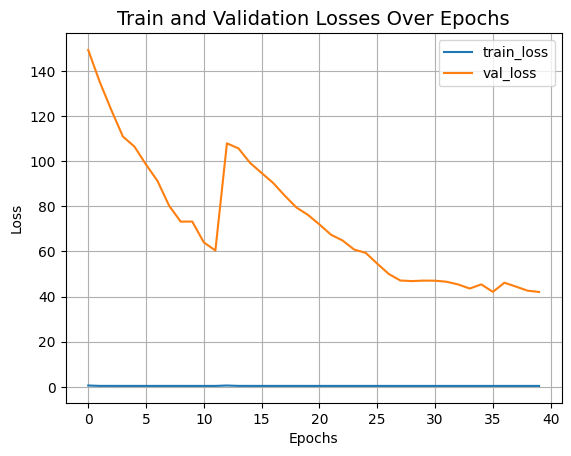

In [21]:
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Losses Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.show()

Let's display the final results of the training on CIFAR-100.

In [22]:
loss, accuracy, top_5_accuracy = model.evaluate(dataset_test)
print(f"Test loss: {round(loss, 2)}")
print(f"Test accuracy: {round(accuracy * 100, 2)}%")
print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

93/93 ━━━━━━━━━━━━━━━━━━━━ 10s 93ms/step - accuracy: 0.9998 - loss: 0.4286 - top-5-accuracy: 1.0000
Test loss: 0.43
Test accuracy: 99.96%
Test top 5 accuracy: 100.0%
